In [12]:

# !pip install gym==0.25.2
# !pip install swig
# !pip install gym[box2d]

In [13]:
# PATH = '/content/drive/MyDrive/Pytorch/rl/Policy_Gradient'
# import os
# os.chdir(PATH)

#Main body

In [14]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random

In [15]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        self.relu = nn.ReLU()

    def forward(self, x, temperature=1.0):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return nn.Softmax(dim=-1)(x / temperature)


In [16]:
class PolicyGradientAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=256, lr=0.001, gamma=0.99, temperature=1.0):
        self.policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.gamma = gamma
        self.temperature = temperature
        self.memory = []

    def choose_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        probs = self.policy_net(state, self.temperature).detach().numpy()[0]
        action = np.random.choice(len(probs), p=probs)
        return action

    def store_transition(self, transition):
        self.memory.append(transition)

    def learn(self):
        states, actions, rewards = zip(*self.memory)

        rewards = normalize_rewards(rewards)  # Normalize rewards

        G = np.zeros_like(rewards, dtype=np.float64)
        for t in range(len(rewards)):
            G_sum = 0
            discount = 1
            for k in range(t, len(rewards)):
                G_sum += rewards[k] * discount
                discount *= self.gamma
            G[t] = G_sum

        G = torch.FloatTensor(G)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)

        self.optimizer.zero_grad()
        loss = 0
        for i in range(len(G)):
            state = states[i]
            action = actions[i]
            Gt = G[i]

            probs = self.policy_net(state)
            log_prob = torch.log(probs[action])
            entropy = -torch.sum(probs * torch.log(probs))
            loss += -log_prob * Gt - 0.01 * entropy  # Entropy regularization

        loss.backward()
        self.optimizer.step()
        self.memory = []

    def save_model(self, path):
        torch.save({
            'model_state_dict': self.policy_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
        }, path)

    def load_model(self, path, device):
        checkpoint = torch.load(path, map_location=device)
        self.policy_net.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.device = device
        self.policy_net.to(device)



In [17]:
def normalize_rewards(rewards):
    rewards = np.array(rewards)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)
    return rewards.tolist()

In [18]:
episodes=2000
max_timesteps=1000
env = gym.make('LunarLander-v2')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PolicyGradientAgent(state_dim, action_dim, temperature=1.0)
rewards_per_episode = []

/home/janak/Documents/Pytorch_CPU/venv/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/janak/Documents/Pytorch_CPU/venv/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [19]:
save_path='policy_gradient_model_3.pth'

In [20]:
try:

    agent.load_model(save_path, device='cpu')
    print("Loading successful")

except FileNotFoundError:
    print("No checkpoint found, starting from scratch.")

No checkpoint found, starting from scratch.


In [21]:
for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    for t in range(max_timesteps):
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.store_transition((state, action, reward))
        state = next_state
        total_reward += reward
        if done:
            break
    agent.learn()
    rewards_per_episode.append(total_reward)

    print(f'Episode {episode + 1}, Reward: {total_reward}')
    if (episode + 1) % 5 == 0:
        agent.save_model(save_path)

        avg_reward = np.mean(rewards_per_episode[-5:])

        if avg_reward >= 200:  # Convergence criteria for Lunar Lander
            agent.save_model(save_path)
            print("Converged!")
            break


/home/janak/Documents/Pytorch_CPU/venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1, Reward: -73.06018325967811
Episode 2, Reward: -73.43989787382839
Episode 3, Reward: -351.78687656024545
Episode 4, Reward: -78.81322990738627
Episode 5, Reward: -151.57358595479513
Episode 6, Reward: -113.60796299960175
Episode 7, Reward: -157.33202330899763
Episode 8, Reward: -170.32972859320176
Episode 9, Reward: -120.85704893270736
Episode 10, Reward: -22.69036048764613
Episode 11, Reward: -168.27597153937745
Episode 12, Reward: -112.69080137420096
Episode 13, Reward: -121.28438711139846
Episode 14, Reward: -252.40742430006514
Episode 15, Reward: 92.51549155850871
Episode 16, Reward: -284.7512154821776
Episode 17, Reward: -117.96845994976357
Episode 18, Reward: -133.69898490793713
Episode 19, Reward: -164.621013830911
Episode 20, Reward: -90.39168365947002
Episode 21, Reward: -88.51248635482747
Episode 22, Reward: -109.39291870466799
Episode 23, Reward: -160.49589017564972
Episode 24, Reward: -199.1438369382881
Episode 25, Reward: -119.33426306605755
Episode 26, Reward: -

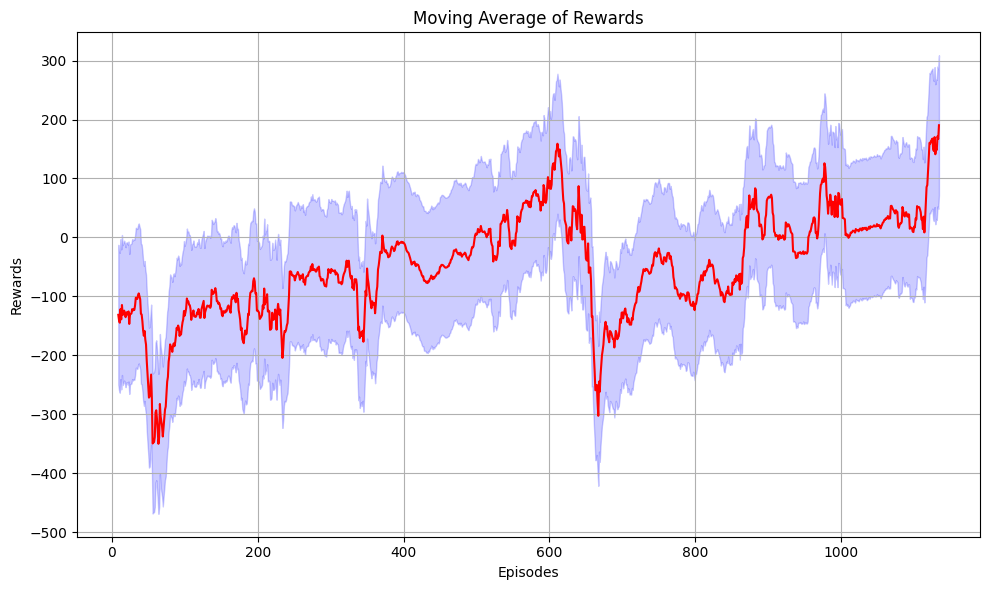

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate some sample data
np.random.seed(0)
data = rewards_per_episode

# Calculate the moving average
window_size = 10
moving_avg = pd.Series(data).rolling(window=window_size).mean()

# Plotting
plt.figure(figsize=(10, 6))

# Plot the moving average line
sns.lineplot(data=moving_avg, color='red')

# Shade the area around the moving average line to represent the range of values
plt.fill_between(range(len(moving_avg)),
                 moving_avg - np.std(data),
                 moving_avg + np.std(data),
                 color='blue', alpha=0.2)

plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Moving Average of Rewards')
plt.grid(True)
# Adjust layout to prevent overlapping elements
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('Episode_rewards.png')
# Show the plot
plt.show()